# Using CTGAN to synthesise data

Source: https://github.com/sdv-dev/CTGAN

- Uses Python to generate synthetic data
- Uses R for evaluation 

In [1]:
from ctgan import CTGANSynthesizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load dataset

In [2]:
df = pd.read_csv("./original_data/satgpa.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      1000 non-null   int64  
 1   sat_v    1000 non-null   int64  
 2   sat_m    1000 non-null   int64  
 3   sat_sum  1000 non-null   int64  
 4   hs_gpa   1000 non-null   float64
 5   fy_gpa   1000 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [14]:
df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63


In [3]:
# Set discrete columns
discrete_cols = [
    'sex'
]

## Generate synthetic data

Since the variable `sat_sum` is the sum of `sat_v` and `sat_m`, we need to drop the column before generating synthetic data.

In [21]:
df_copy = df.copy(deep=True)

df_copy = df_copy.drop(columns=['sat_sum'])

df_copy.head()

,sex,sat_v,sat_m,hs_gpa,fy_gpa
0,1,65,62,3.40,3.18
1,2,58,64,4.00,3.33
2,2,56,60,3.75,3.25
3,1,42,53,3.75,2.42
4,1,55,52,4.00,2.63


In [18]:
# Initialise and fit GAN
model = CTGANSynthesizer(batch_size=250, discriminator_steps=3, generator_lr=2e-3, discriminator_lr=2e-3)
model.fit(df_copy, discrete_cols)

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 

Can ignore warnings as per developer's comments: https://github.com/sdv-dev/SDGym/issues/44

In [19]:
synth_df = model.sample(1000)

In [20]:
synth_df.head()

,sex,sat_v,sat_m,hs_gpa,fy_gpa
0,1,46,46,2.687051,1.831997
1,2,42,57,2.984383,1.633556
2,1,44,48,2.656724,2.752115
3,1,52,59,2.627774,3.301292
4,1,50,45,2.595438,1.590625


In [24]:
# Add sat_sum back on
sat_sum = synth_df['sat_v'] + synth_df['sat_m']
synth_df.insert(loc=3, column='sat_sum', value=sat_sum)

# Round to 2-decimal places
synth_df = synth_df.round(2)

synth_df.head()

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,46,46,92,2.69,1.83
1,2,42,57,99,2.98,1.63
2,1,44,48,92,2.66,2.75
3,1,52,59,111,2.63,3.30
4,1,50,45,95,2.60,1.59


In [25]:
# Paths
synth_model = "./synth_data/ctgan_model.pkl"
synth_output = "./synth_data/ctgan_method.csv"

# Output
model.save(synth_model)
synth_df.to_csv(synth_output, sep=",")

## Evaluation

We used an R package called Synthpop to perform evaluations. This lets us compare with CART methods.

In [6]:
# Read in synth data
synth_df = pd.read_csv(synth_output)

In [8]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

C:\Users\kooste\.virtualenvs\kooste-Y9QsWDTI\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


### Visualise
First, we visualise the univariate distributions for each variable.

R[write to console]: Find out more at https://www.synthpop.org.uk/




Comparing percentages observed with synthetic

Press return for next variable(s): 


Selected utility measures:
           S_pMSE df
sex      1.444244  1
sat_v    9.512296  4
sat_m    5.617619  4
sat_sum 10.111462  4
hs_gpa  10.411141  4
fy_gpa  15.345299  4


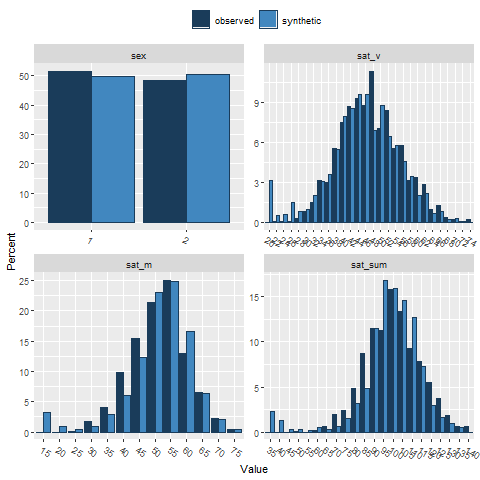

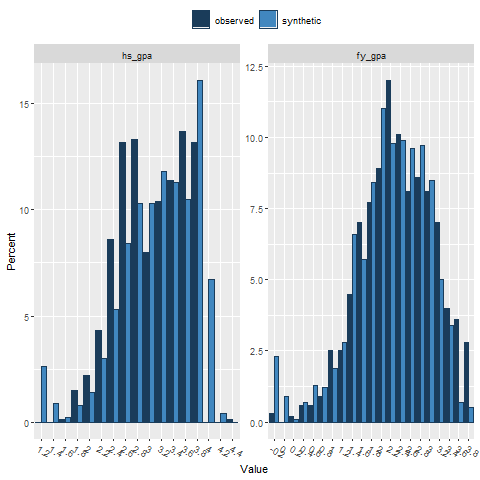

In [28]:
%%R -i df,synth_df

library(synthpop)

synthpop::compare(synth_df, df, utility.stats = c("S_pMSE", "df"))

### Utility scores

Visualises utility for all two-way tables.

A higher utility score is worse.


Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
5.hs_gpa:6.fy_gpa   2.sat_v:3.sat_m  2.sat_v:6.fy_gpa  2.sat_v:5.hs_gpa 
          13.0363            9.7939            8.4389            8.4284 
   1.sex:6.fy_gpa 
           8.0129 

Table of selected utility measures
                         VW       FT    JSD SPECKS WMabsDD        U        G
1.sex:2.sat_v       45.1411  45.4878 0.0082  0.076 19.2540 556479.5  46.6655
1.sex:3.sat_m       43.8940  44.2711 0.0080  0.083 21.7217 555625.0  45.9815
1.sex:4.sat_sum     53.0591  53.4312 0.0096  0.096 24.0701 565717.5  53.4057
1.sex:5.hs_gpa      51.7516  52.0501 0.0094  0.101 24.7867 564452.0  52.3766
1.sex:6.fy_gpa      72.1161  72.8312 0.0131  0.109 27.3085 574574.5  71.9464
2.sat_v:3.sat_m    235.0525 247.5933 0.0438  0.190 77.3385 634603.5 267.2205
2.sat_v:4.sat_sum  180.5507 202.6222 0.0345  0.157 69.3222 611221.5 199.5155
2.sat_v:5.hs_gpa   202.2808 211.3508 

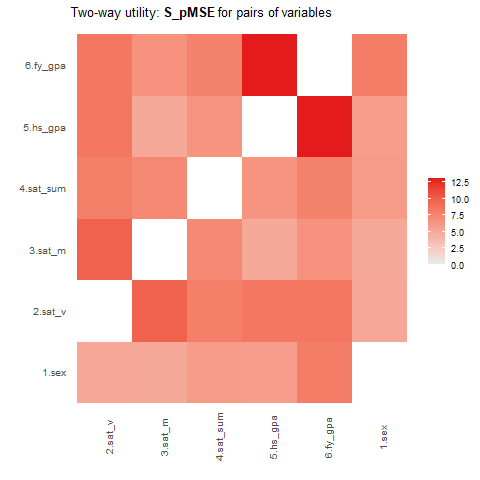

In [29]:
%%R -i df,synth_df

utility.tables(synth_df, df, tab.stats = "all", tables = "twoway", print.tabs = TRUE)

## Testing different parameters for write up

In [41]:
from datetime import datetime

def run_ctgan(*args, **kwargs):
    """ Easy way to alter hyperparameters for CTGAN.
    Depends: on the post_process()
    Returns: synthetic dataset with sample size = 1000
    Also prints crude measure of run time for model. """
    # Model generation
    start_time = datetime.now()
    model = CTGANSynthesizer(*args, **kwargs)
    model.fit(df_copy, discrete_cols)
    end_time = datetime.now()
    run_time = end_time - start_time
    print("Run time: ", run_time)
    # Generate synthetic data
    synth_df = model.sample(1000)
    synth_df = post_process(synth_df)
    return(synth_df)

# Set up post-processing pipeline
def post_process(df):
    # Add sat_sum back on
    sat_sum = df['sat_v'] + df['sat_m']
    df.insert(loc=3, column='sat_sum', value=sat_sum)
    # Round to 2-decimal places
    df = df.round(2)
    return(df)

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Enables R in the notebook, only need to run once
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
%%R
library(synthpop)

R[write to console]: Find out more at https://www.synthpop.org.uk/



### Varying batch size

#### Default

In [42]:
synth_df = run_ctgan(batch_size=500)

Run time:  0:00:54.696163



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
    1.sex:2.sat_v   2.sat_v:3.sat_m 2.sat_v:4.sat_sum  2.sat_v:6.fy_gpa 
          74.9613           41.7802           39.9850           38.7384 
 2.sat_v:5.hs_gpa 
          38.5989 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE    0.04 0.0627

For more details of all scores use print.tabs = TRUE.


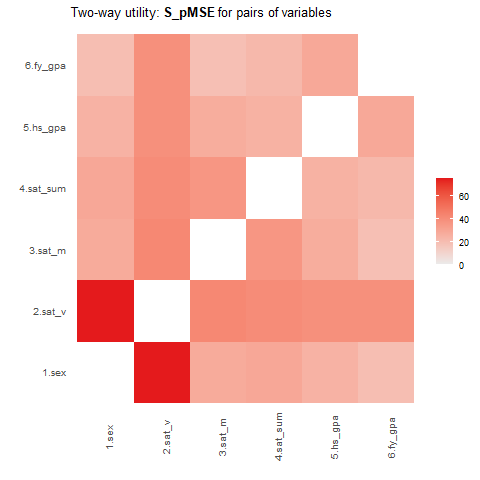

In [43]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Half default batch size

In [44]:
synth_df = run_ctgan(batch_size=250)

Run time:  0:01:11.699051



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
   1.sex:6.fy_gpa  2.sat_v:6.fy_gpa 5.hs_gpa:6.fy_gpa   2.sat_v:3.sat_m 
          36.1387           22.1303           19.2550           18.7643 
 3.sat_m:6.fy_gpa 
          17.5568 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0221 0.0332

For more details of all scores use print.tabs = TRUE.


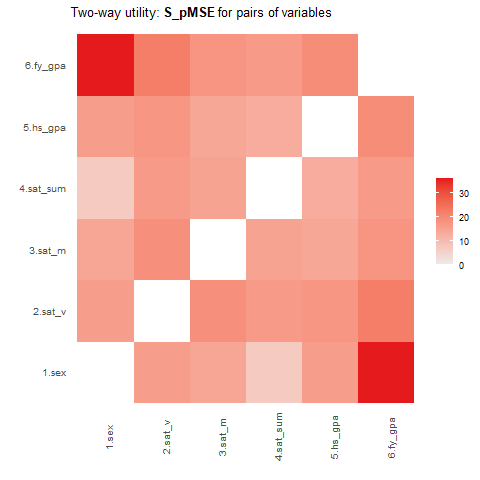

In [45]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### A quarter default batch size
Round down to nearest 10

In [46]:
synth_df = run_ctgan(batch_size=120)

Run time:  0:01:45.138289



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
    1.sex:3.sat_m   1.sex:4.sat_sum 5.hs_gpa:6.fy_gpa   2.sat_v:3.sat_m 
          18.6483           13.9377           10.1055            9.3517 
    1.sex:2.sat_v 
           8.3796 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0078 0.0152

For more details of all scores use print.tabs = TRUE.


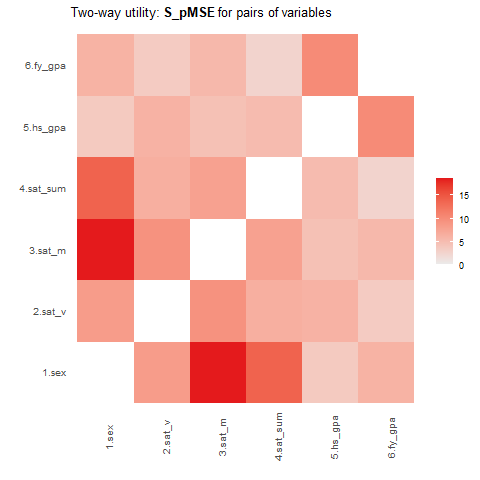

In [47]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Very small batch size

In [48]:
synth_df = run_ctgan(batch_size=10)

Run time:  0:12:41.254109



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
    1.sex:3.sat_m 3.sat_m:4.sat_sum   2.sat_v:3.sat_m  3.sat_m:5.hs_gpa 
          41.5331           24.8029           24.6253           23.3031 
2.sat_v:4.sat_sum 
          20.5516 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0197 0.0369

For more details of all scores use print.tabs = TRUE.


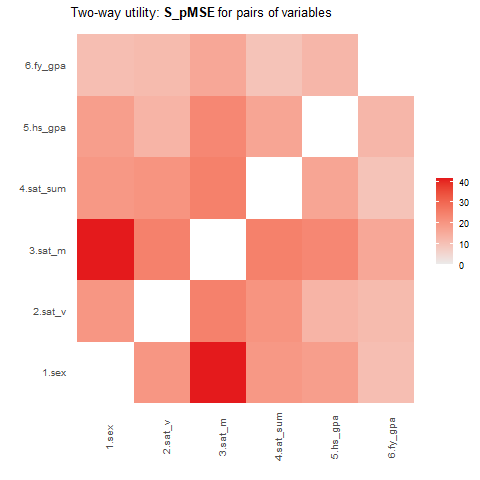

In [49]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

### Varying discriminator steps

Default discriminator steps is 1. So not tested.

#### Increase step count to 3

In [50]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=3)

Run time:  0:04:08.054588



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
   1.sex:4.sat_sum      1.sex:2.sat_v      1.sex:3.sat_m     1.sex:6.fy_gpa 
           15.5639            13.5604            13.3687            13.1664 
4.sat_sum:6.fy_gpa 
           10.3077 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0103 0.0155

For more details of all scores use print.tabs = TRUE.


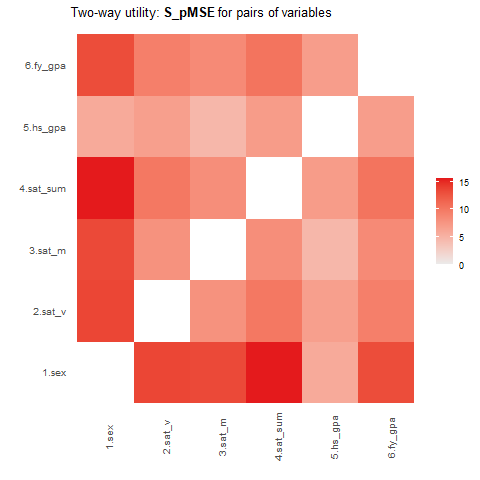

In [51]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Increase steps to 5

In [52]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5)

Run time:  0:06:12.972173



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
 5.hs_gpa:6.fy_gpa     1.sex:5.hs_gpa 4.sat_sum:5.hs_gpa   2.sat_v:5.hs_gpa 
            9.5641             8.4774             8.4352             7.8994 
     1.sex:3.sat_m 
            7.8246 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0065 0.0143

For more details of all scores use print.tabs = TRUE.


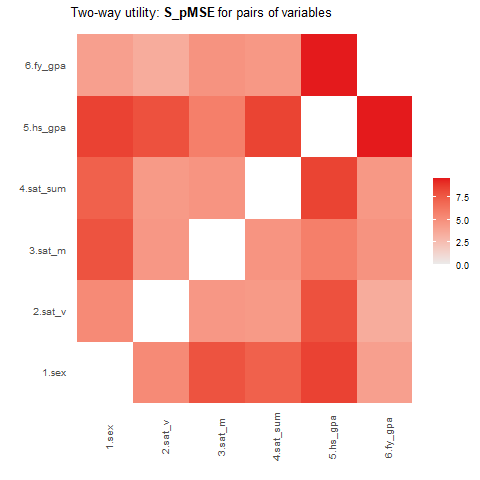

In [53]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

### Learning rate

Increase step size for both disciminator and critic together. Just makes it easier to test.

Increase by factor 10.

#### Learning rate 2e-3

In [54]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5, generator_lr=2e-3, discriminator_lr=2e-3)

Run time:  0:06:14.576228



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
    1.sex:2.sat_v  2.sat_v:5.hs_gpa  2.sat_v:6.fy_gpa 2.sat_v:4.sat_sum 
          26.4846           19.1325           18.2768           16.3589 
  2.sat_v:3.sat_m 
          16.1405 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.0179 0.0287

For more details of all scores use print.tabs = TRUE.


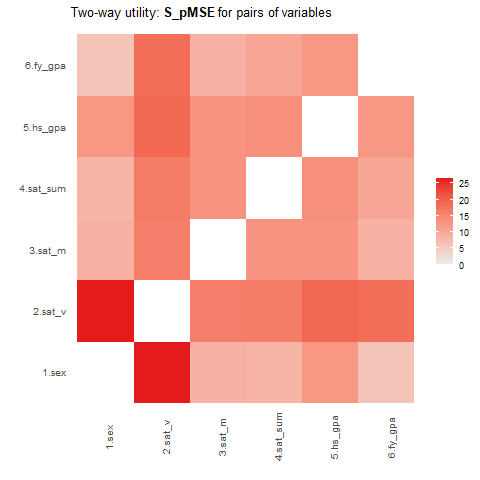

In [55]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Learning rate 2e-2

In [56]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5, generator_lr=2e-2, discriminator_lr=2e-2)

Run time:  0:06:51.823546



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
   1.sex:2.sat_v    1.sex:3.sat_m   1.sex:6.fy_gpa   1.sex:5.hs_gpa 
        297.8282         281.7092         260.6945         254.4755 
2.sat_v:6.fy_gpa 
        157.3115 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.1923 0.2261

For more details of all scores use print.tabs = TRUE.


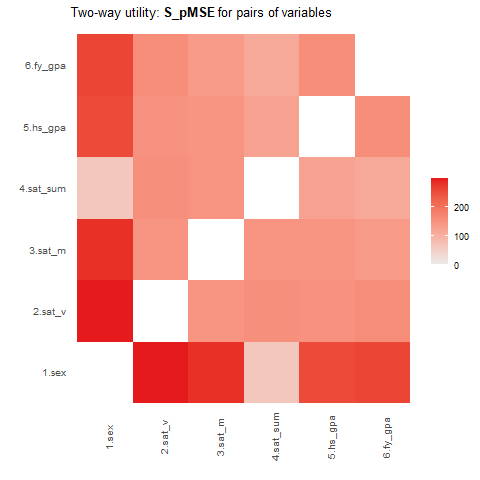

In [57]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Learning rate 2e-1

In [58]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5, generator_lr=2e-1, discriminator_lr=2e-1)

Run time:  0:06:22.588044



Two-way utility: S_pMSE value plotted for 15 pairs of variables.

Variable combinations with worst 5 utility scores (S_pMSE):
   1.sex:5.hs_gpa     1.sex:2.sat_v    1.sex:6.fy_gpa   1.sex:4.sat_sum 
         568.1341          561.2370          540.2162          503.7889 
3.sat_m:4.sat_sum 
         489.5991 

Medians and maxima of selected utility measures for all tables compared
     Medians Maxima
pMSE  0.2312   0.25

For more details of all scores use print.tabs = TRUE.


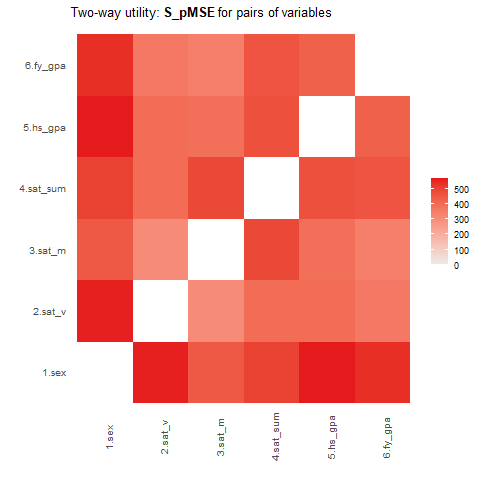

In [59]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Learning rate 2

In [ ]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5, generator_lr=2, discriminator_lr=2)

In [ ]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")

#### Learning rate 20

In [ ]:
synth_df = run_ctgan(batch_size=120, discriminator_steps=5, generator_lr=20, discriminator_lr=20)

In [ ]:
%%R -i df,synth_df
utility.tables(synth_df, df, tab.stats = "pMSE", tables = "twoway")